Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\LK_and_commets 
Оттуда буду брать данные, там должна быть папка data, а в ней данные по годам


c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


Это pandas DataFrame!


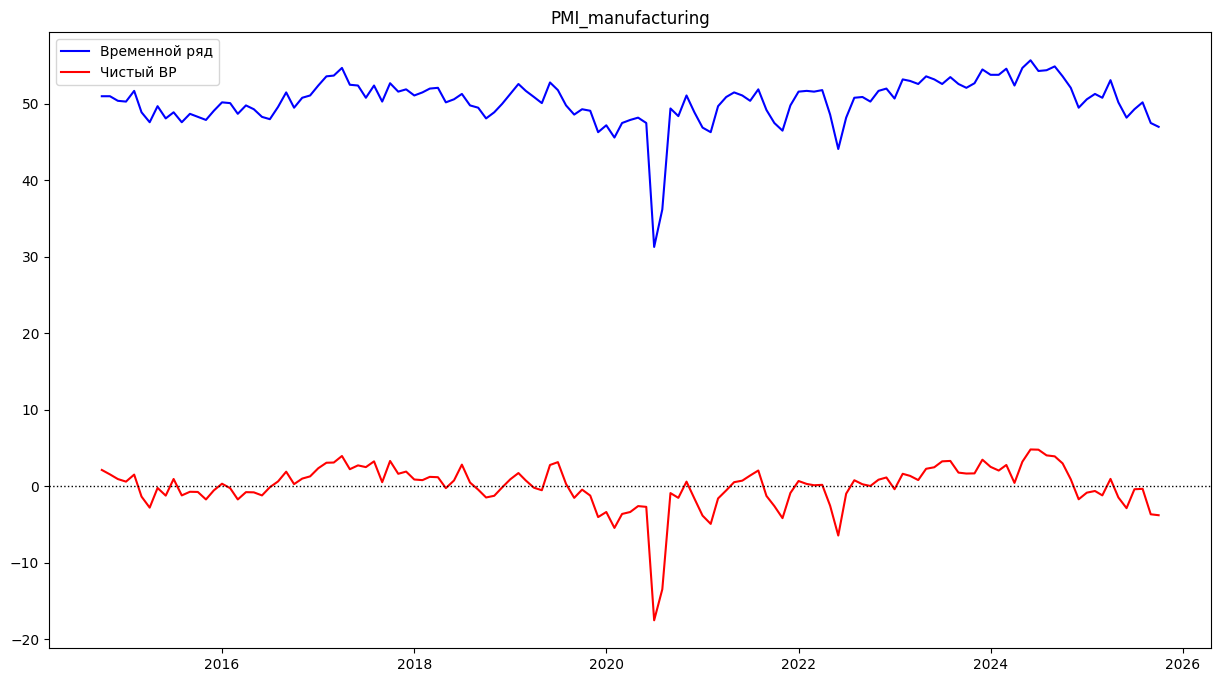

Исходный ряд PMI_manufacturing оказался стационарным


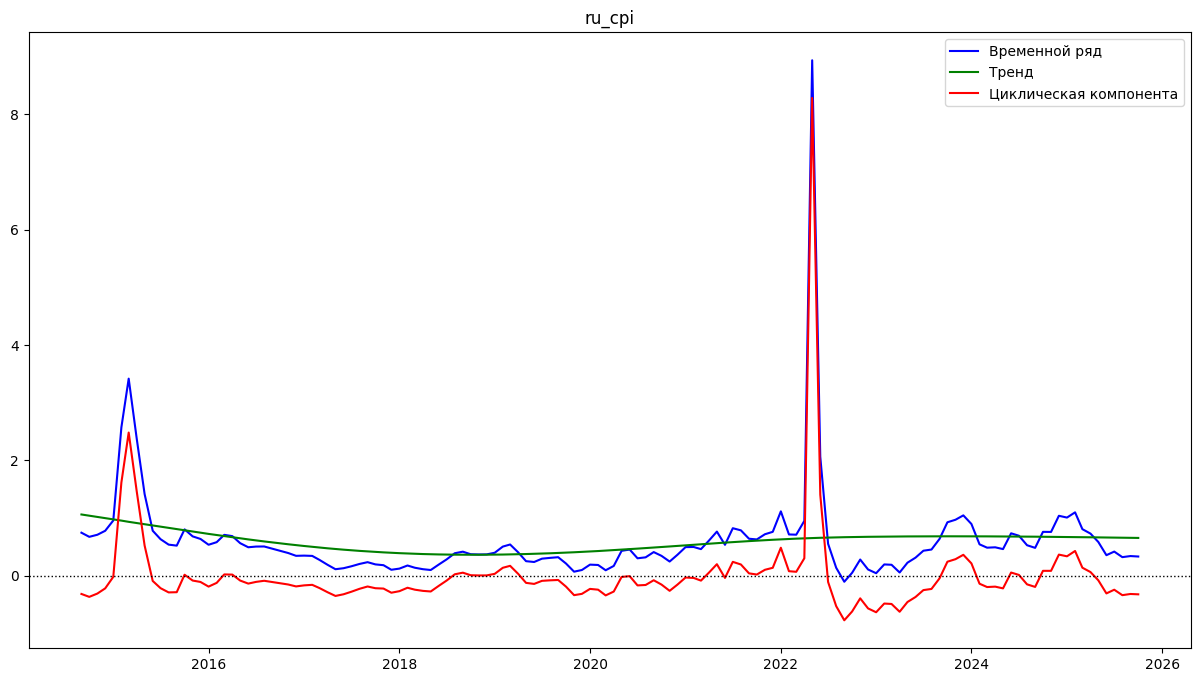

Исходный ряд ru_cpi оказался стационарным


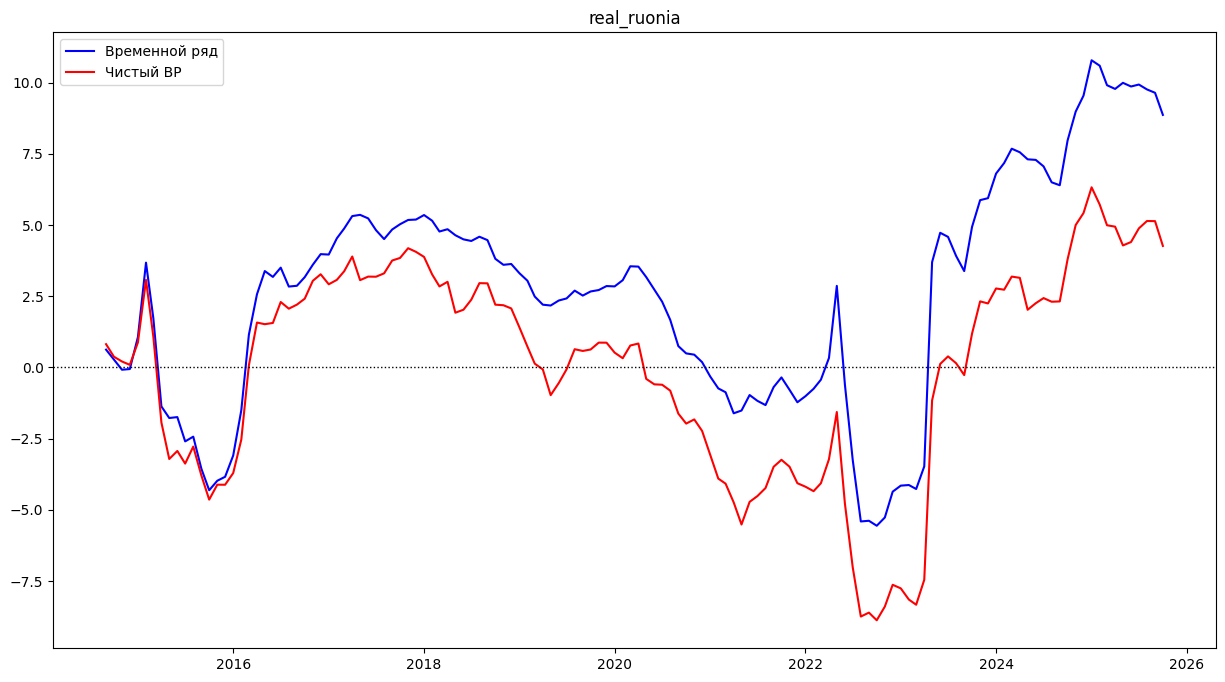

Исходный ряд real_ruonia оказался стационарным


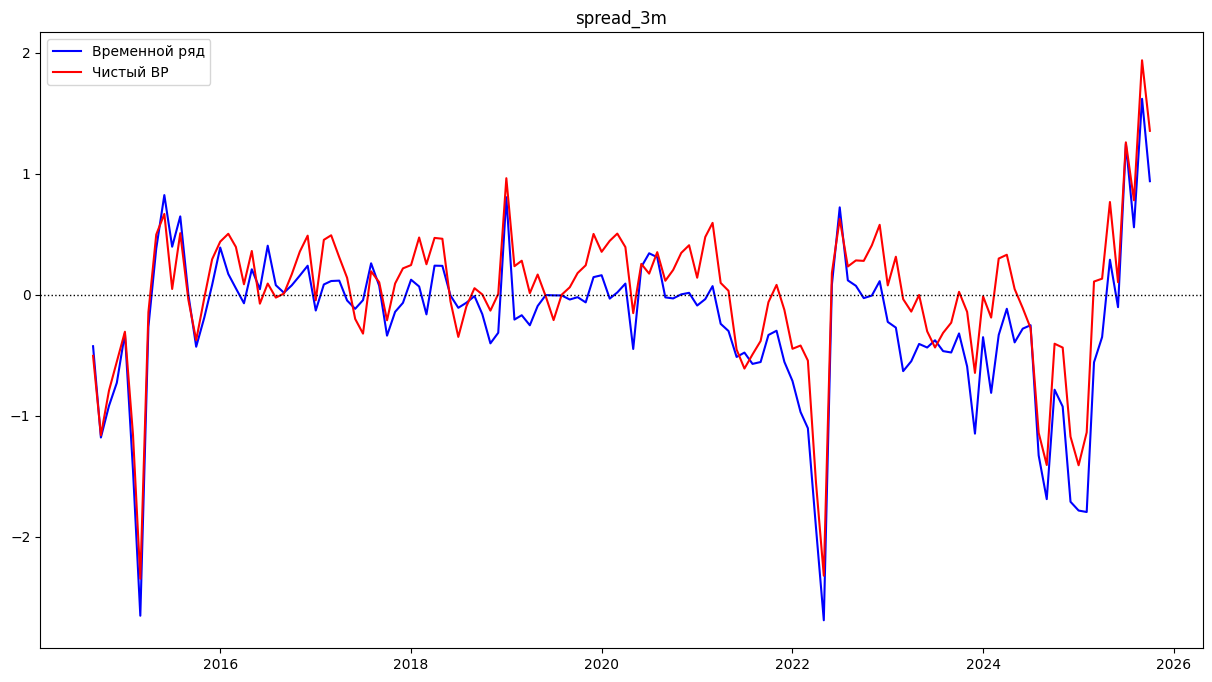

Исходный ряд spread_3m оказался стационарным


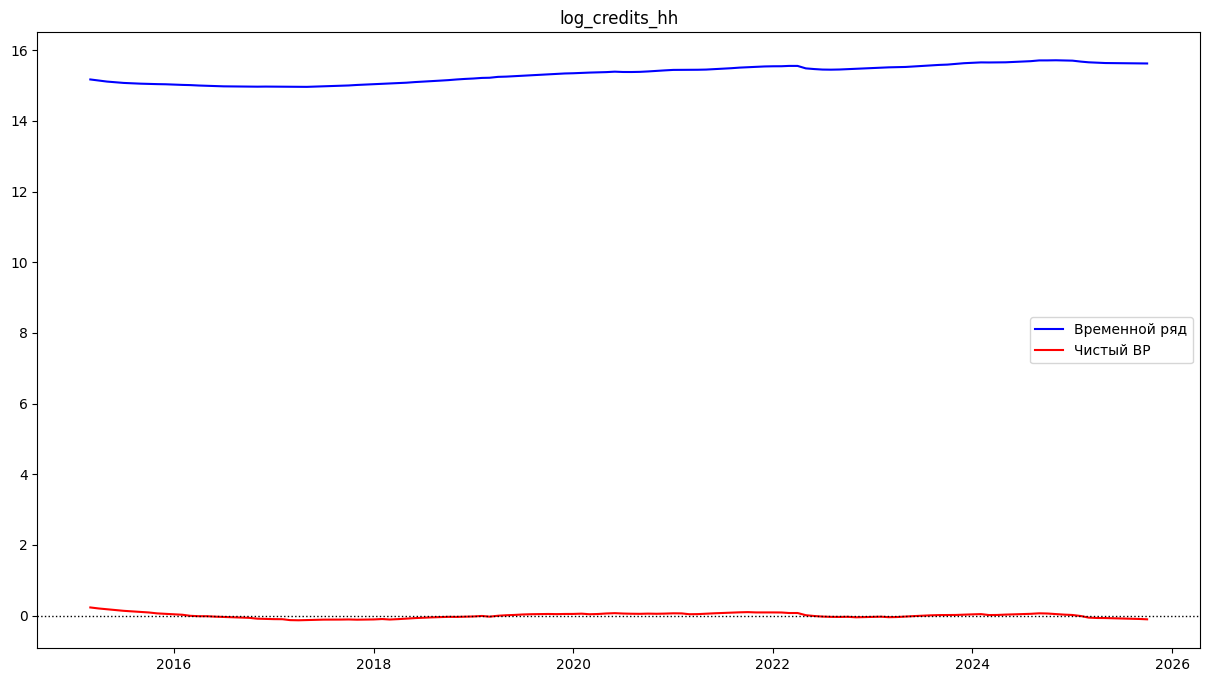

Исходный ряд log_credits_hh оказался стационарным


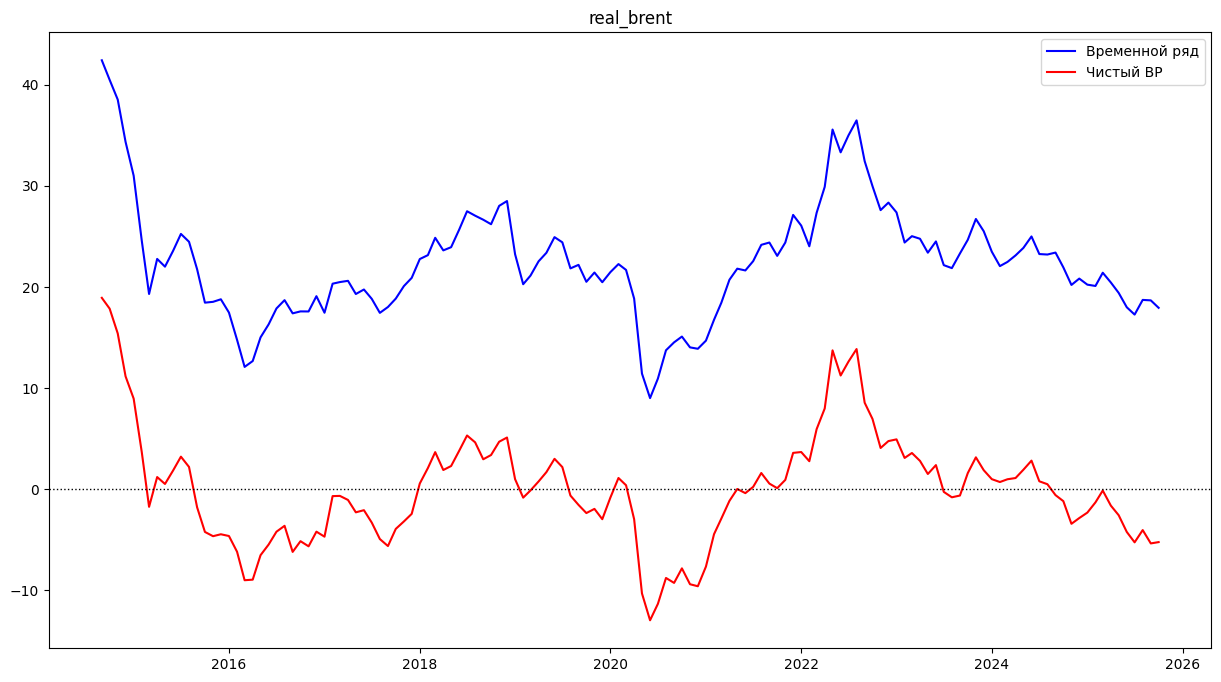

Исходный ряд real_brent оказался стационарным
Обрати внимание, что для переменной var_name есть пробел в данных
между 73 и 68 наблюдениями длинной больше 2


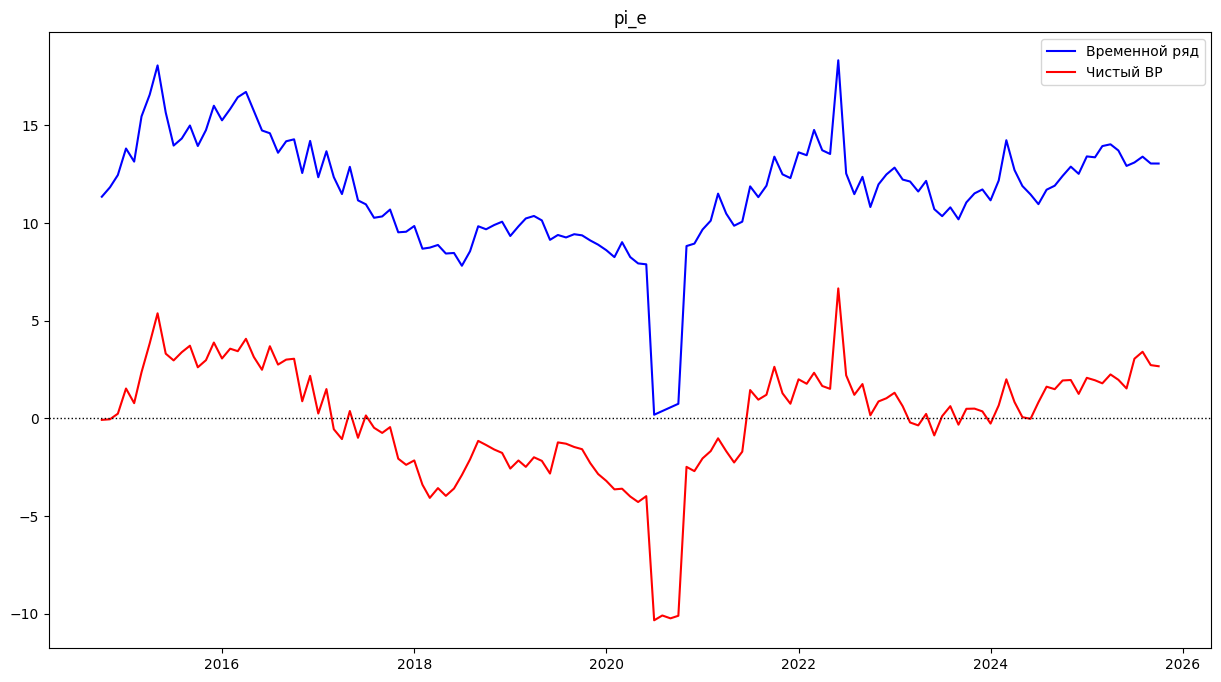

Исходный ряд pi_e оказался стационарным


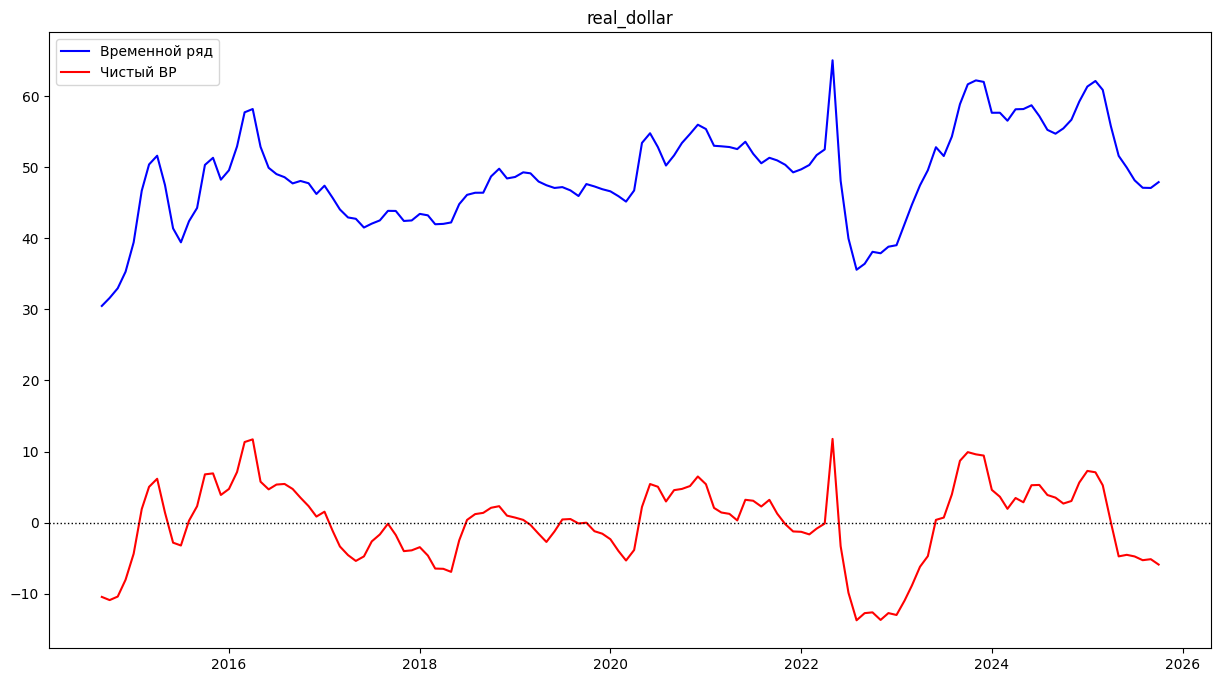

Исходный ряд real_dollar оказался стационарным


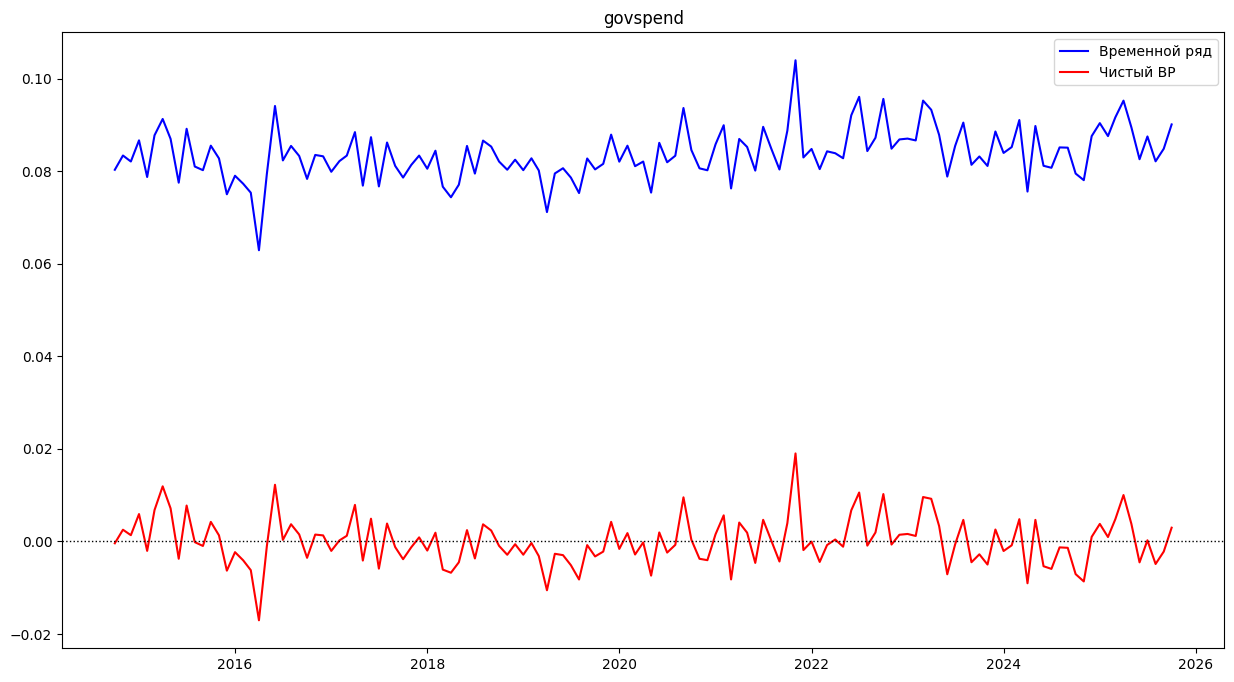

Исходный ряд govspend оказался стационарным


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from cleaning import clean
from get_macrodata import monthly_data
import sys
from scipy.optimize import minimize

monthly_data['spread'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'rate_1']
monthly_data['spread_3m'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'ruonia_3m']
monthly_data['spread_1m'] =  monthly_data.loc[:, 'ruonia'] - monthly_data.loc[:, 'ruonia_1m']

var_spec = clean(monthly_data.loc[monthly_data.index > dt(2014, 6, 1), ['PMI_manufacturing', 'ru_cpi', 'real_ruonia', 'spread_3m',
                                                                         'log_credits_hh', 'real_brent', 'pi_e', 'real_dollar', 'govspend']])
monthly_data['pi_spread'] =  monthly_data.loc[:, 'pi_e_wos'] - monthly_data.loc[:, 'pi_e_ws']
monthly_data['spread'].notna().sum()

df, data = var_spec.LOS(use_harmonics=False, only_KPSS = True, hp_filter_map={
                                                                               'ru_cpi': True,
                                                                               'real_rate': False,
                                                                               'm2x_sa_mom': True})
covid_start, duration_covid = (data.T.index < dt(2020, 3, 1)).sum(), 5
svo_start, svo_duration = (data.T.index < dt(2022, 2, 1)).sum(), 2

data = data.T.sort_index(ascending=False).T.copy(deep=True)
data.loc['covid', :] = np.concatenate([np.zeros(data.shape[1]-covid_start-duration_covid), np.ones(duration_covid), np.zeros(covid_start)])
#data.loc['svo', :] = np.concatenate([np.zeros(svo_start), np.ones(svo_duration), np.zeros(data.shape[1]-svo_start-svo_duration)])
data = data.copy(deep = True)
data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))] = data.loc['pi_e', (data.T.index > dt(2020, 3, 1)) & (data.T.index < dt(2020, 8, 1))].copy() +7

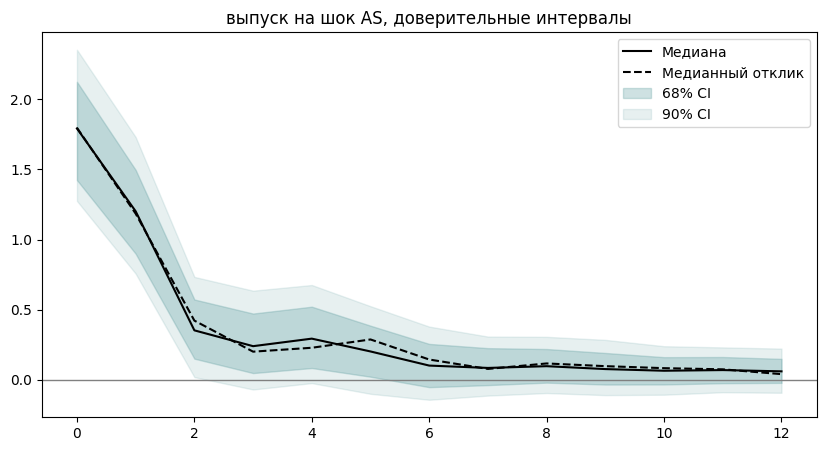

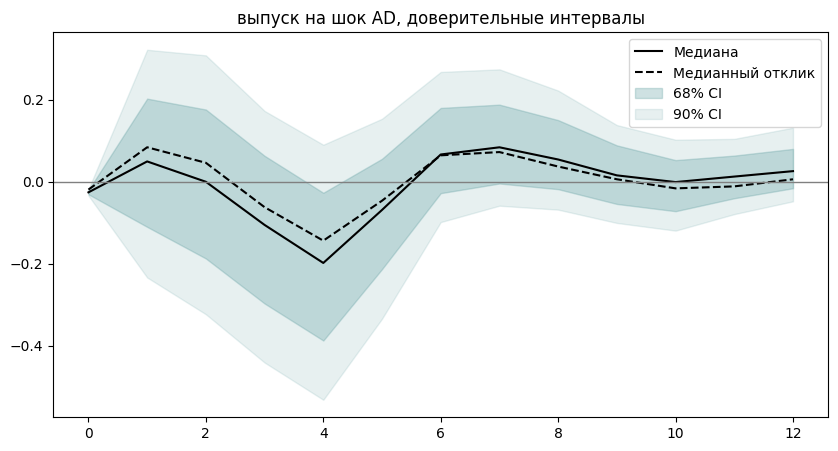

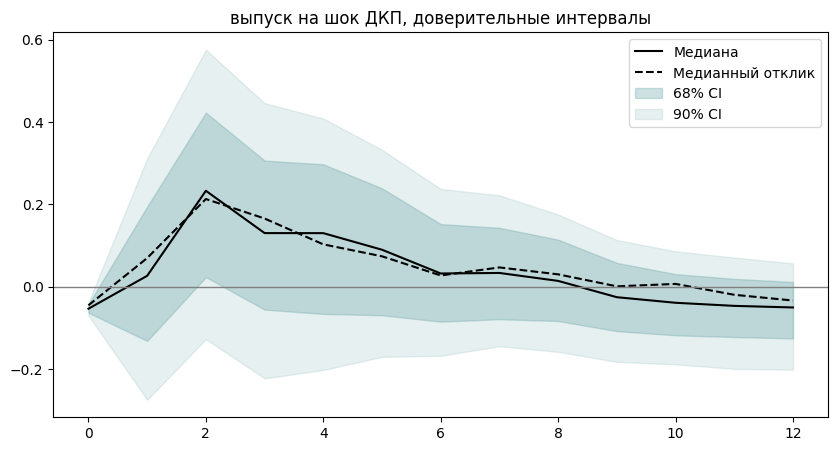

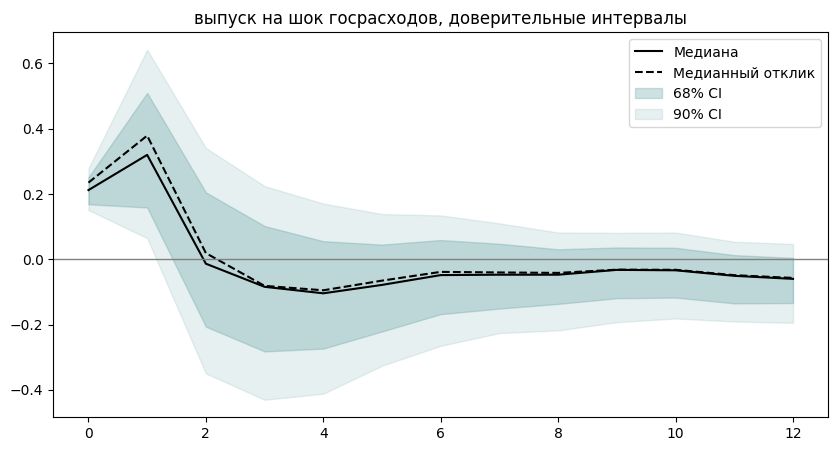

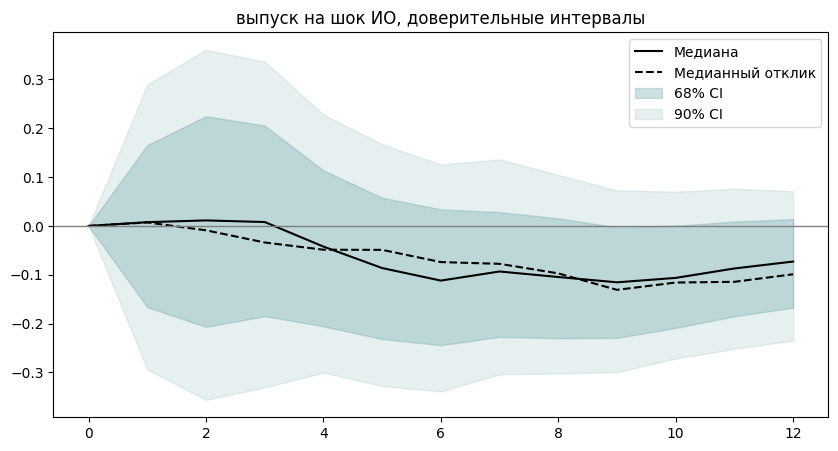

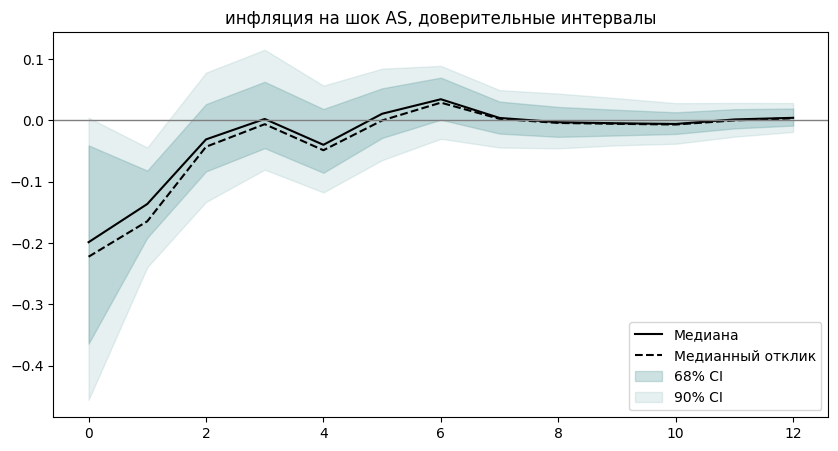

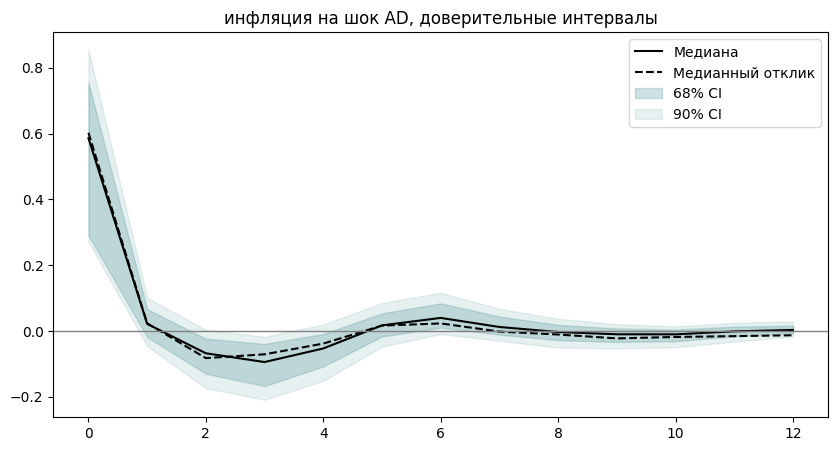

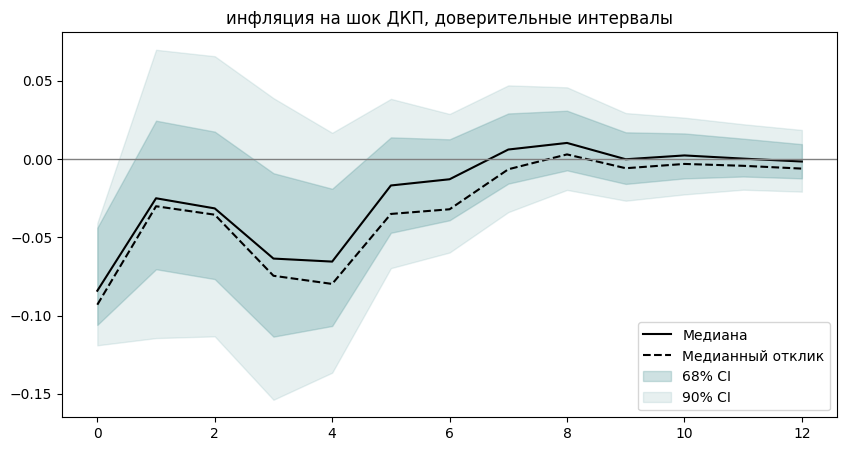

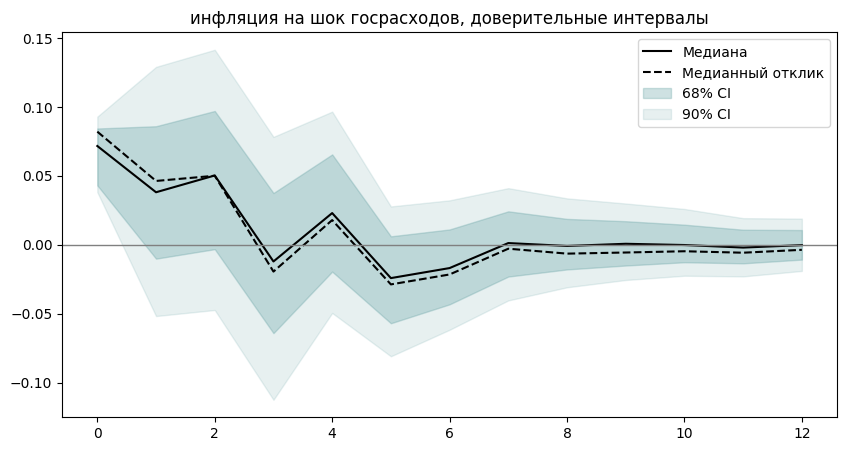

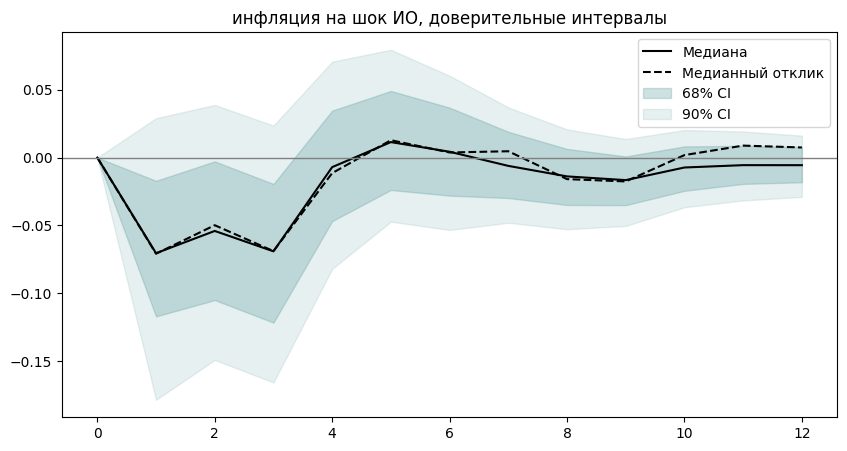

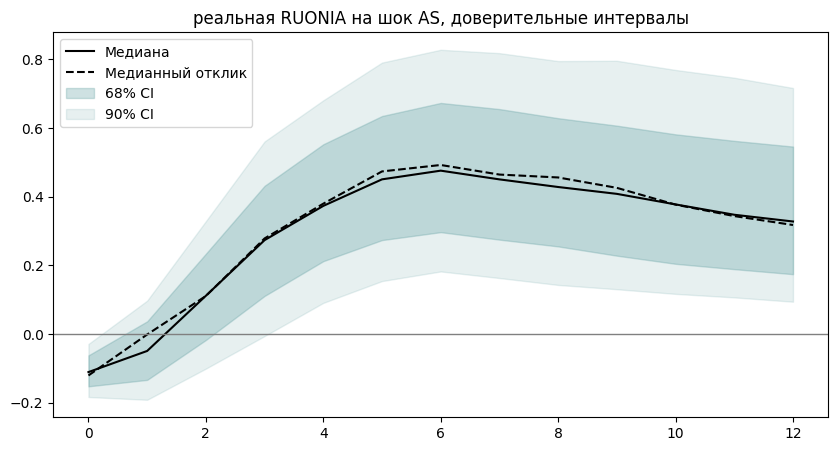

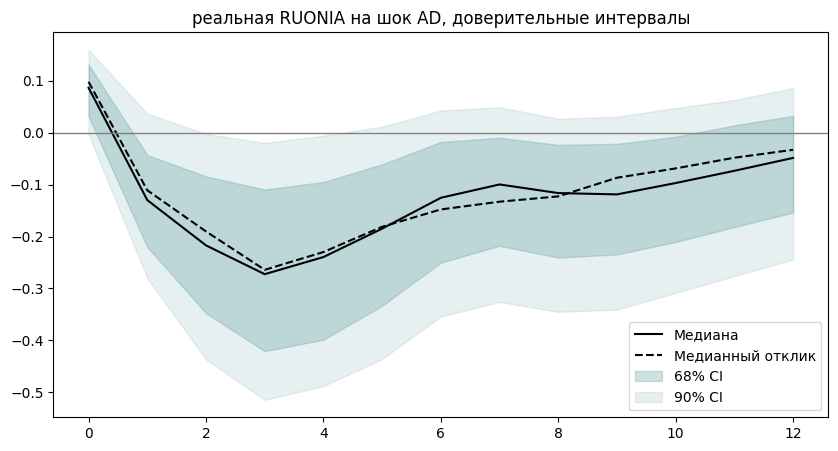

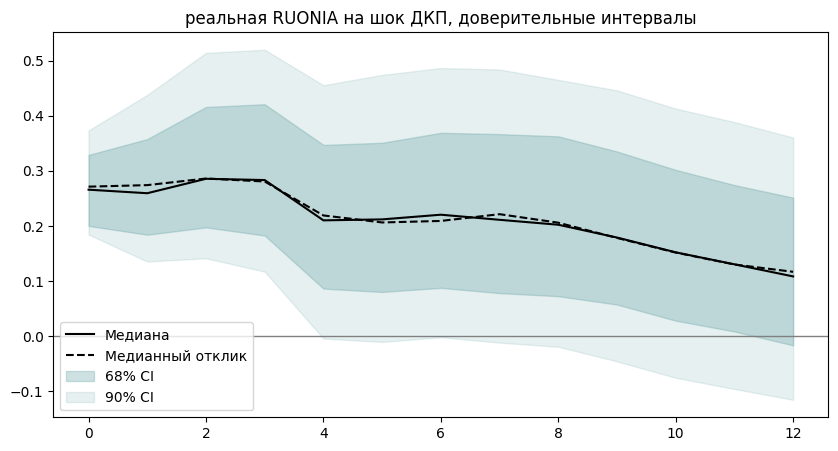

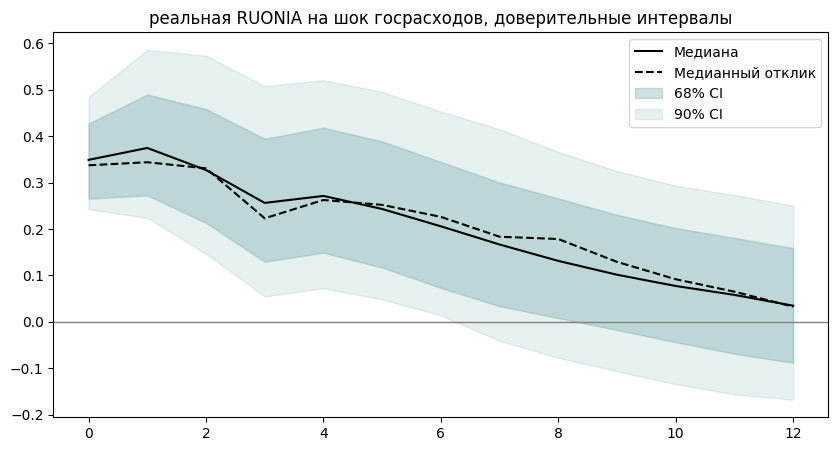

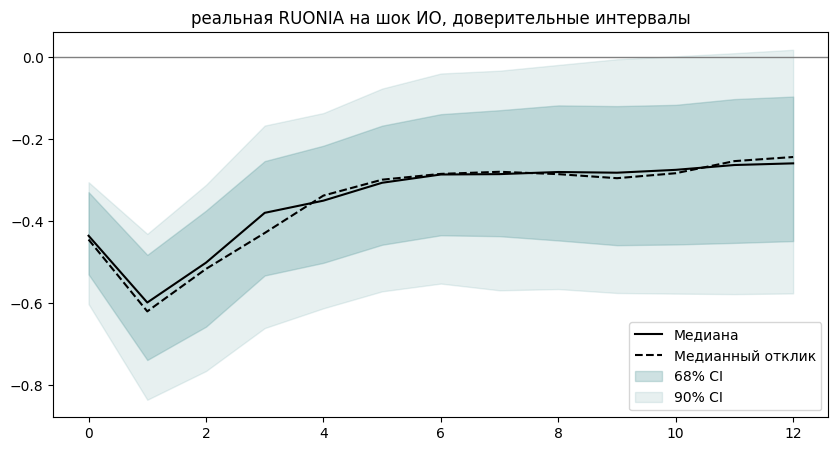

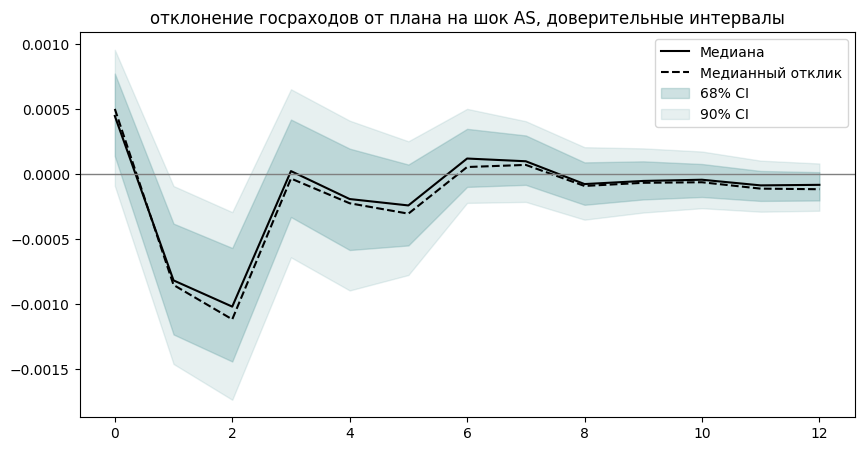

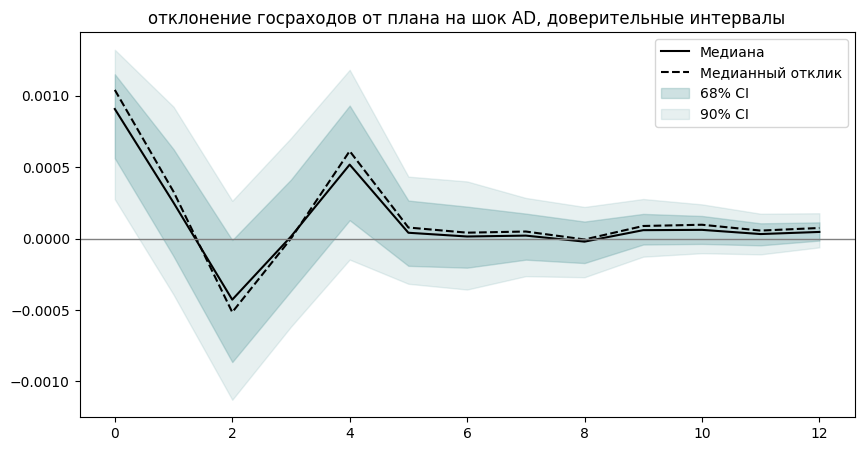

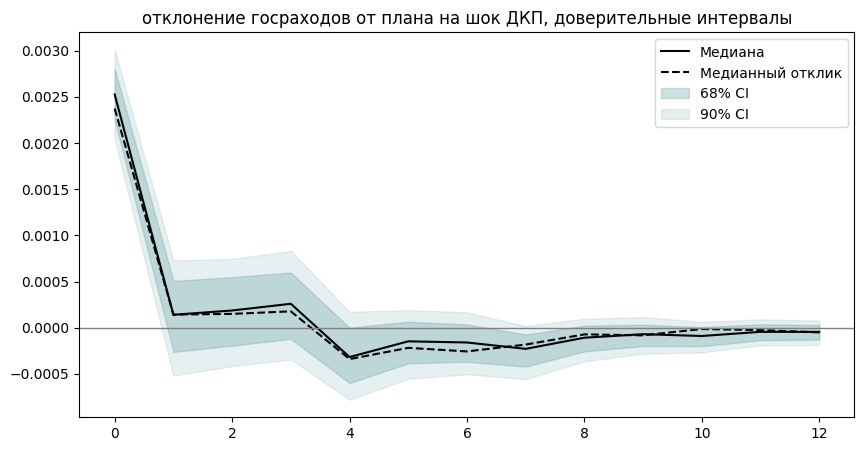

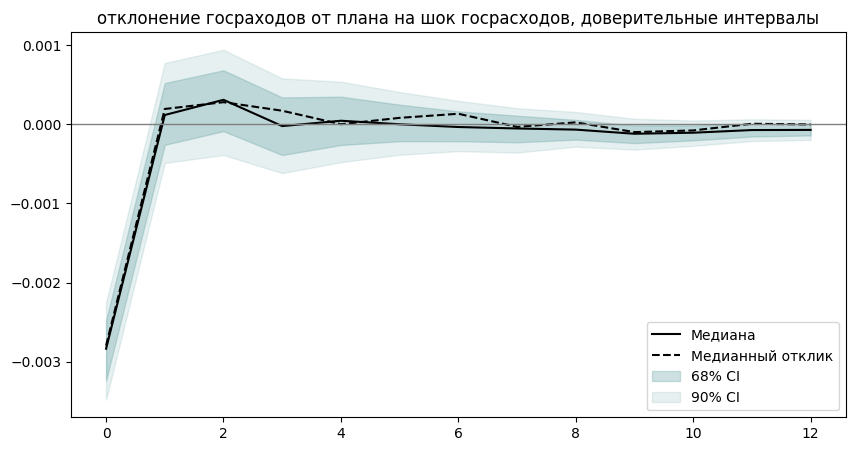

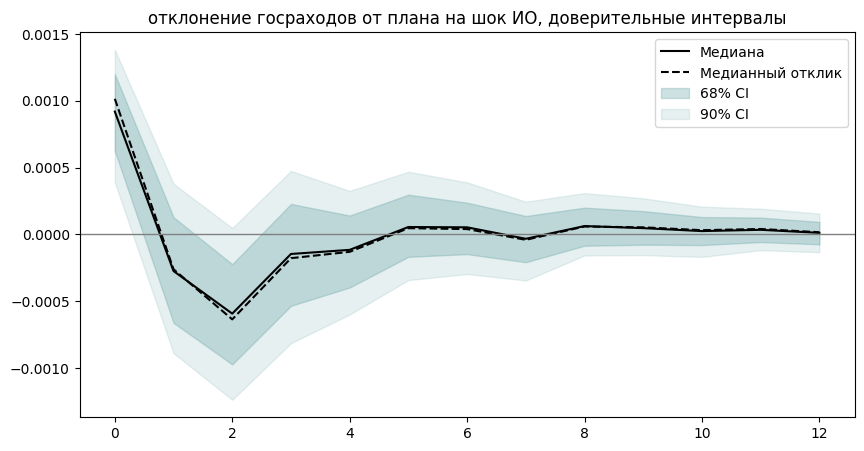

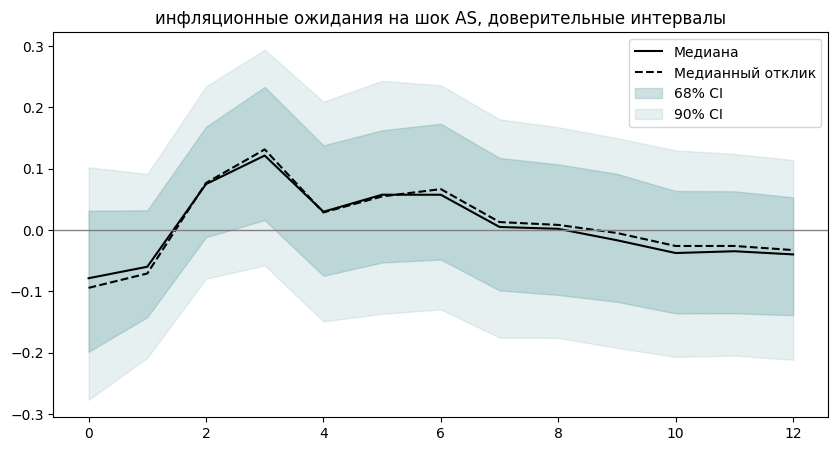

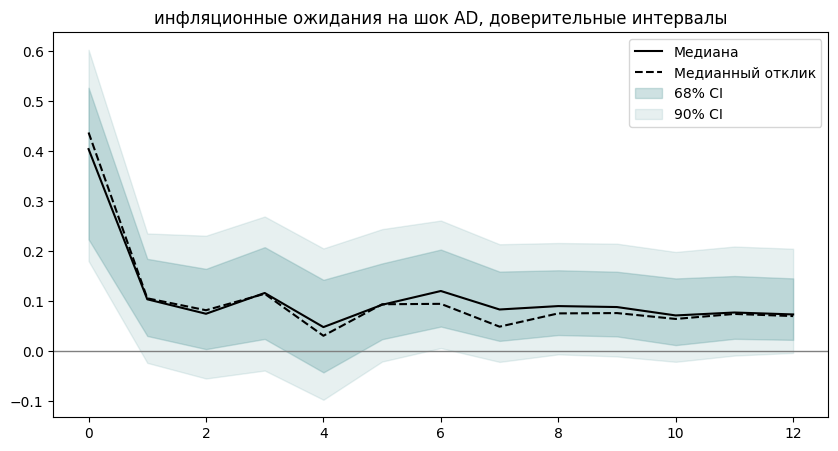

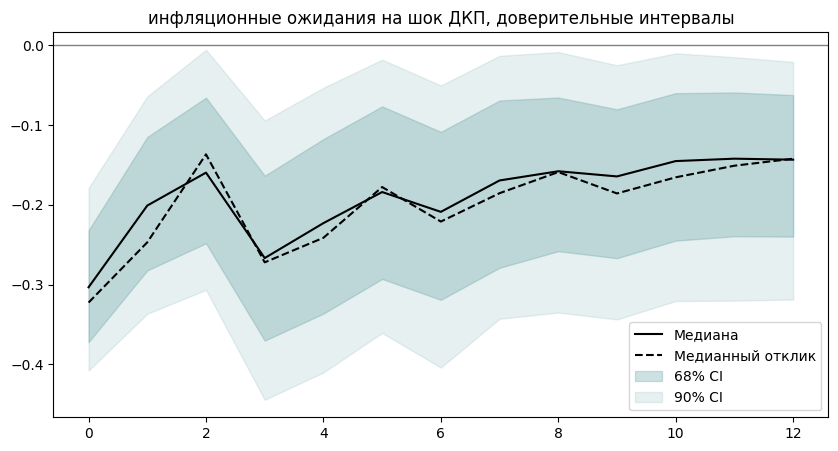

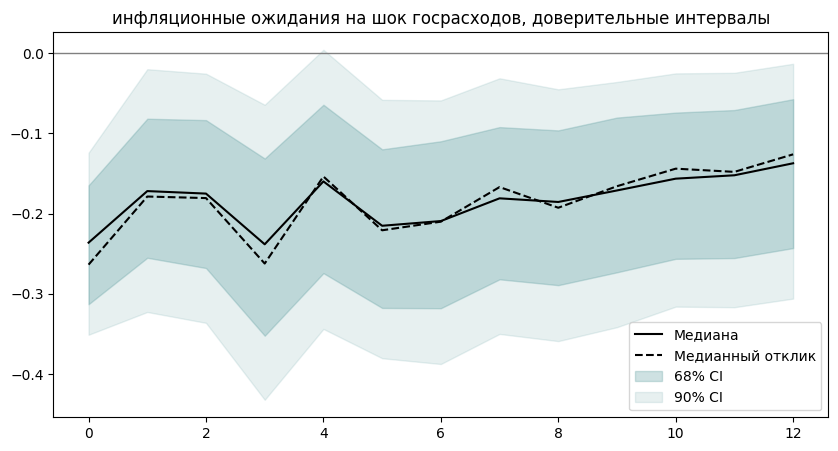

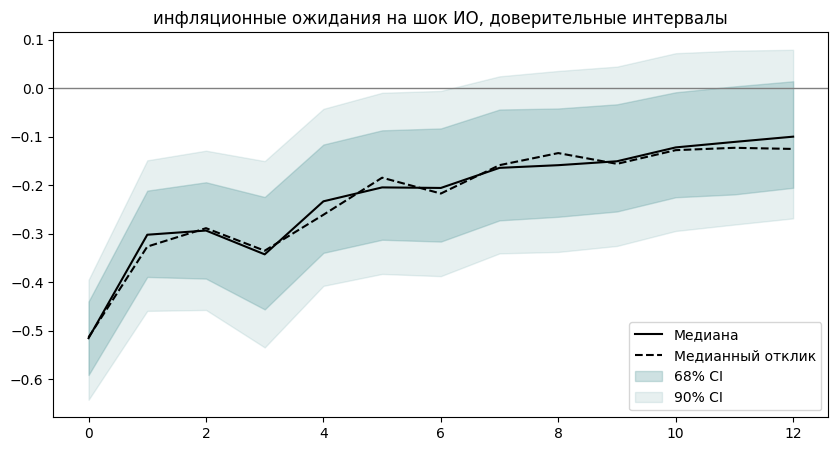

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from structuralvar import Clean, SVAR_KL


#data = pd.read_pickle('data.pkl')
lag = 4

endog_names = ['PMI_manufacturing', 'ru_cpi', 'real_ruonia', 'govspend', 'pi_e']
exog_names  = ['real_brent']

df_endog = data.loc[endog_names, :]   # K×T
df_exog  = data.loc[exog_names, :]    # K_ex×T

model = SVAR_KL(
    data=df_endog,
    p=lag,
    exog=df_exog,              #
    layout="KL_KxT",
    time_order="KL_reverse",
    add_const=True,
).fit_ols()

# Всякие 
Z = model.Z
Y = model.Y
B_hat = model.B_hat
E = model.E
K, T = model.K, model.T
B_hat_endo = model.B_hat_endo
P = model.P

short_run_zeros = [(0,1), (0,2), (1, 2), (3, 0), (3, 1)] #
long_run_zeros  = [(2,2), (3,3)]


short_sign_restrictions = [
    (2, 2, 0, 1),
    (2, 2, 1, 1),
    (2, 2, 2, 1),
    (2, 2, 3, 1),
    (3, 3, 0, 1),
    (3, 3, 1, 1),
    (3, 3, 2, 1),
    (3, 3, 3, 1),
    (1, 2, 1,-20),
    (1, 2, 2,-20),
    (0, 0, 0, 1),
    (0, 3, 0, 1),
    (0, 3, 1, 1),
    (1, 1, 0, 1),
    (2, 2, 0, 1),
    (0, 2, 1,-1),
    (0, 2, 2,-1),
    (0, 3, 0,-1),
]
long_sign_restrictions = [

]

rr = model.identify_combined(
    short_run_zeros=short_run_zeros,
    long_run_zeros=long_run_zeros,
    short_sign_restrictions=short_sign_restrictions,
    long_sign_restrictions=long_sign_restrictions,
    n_starts=100,
    seed=100,
    method="BFGS",
)

Q = model.Q
B0inv = model.B0inv          # это P@Q
Upsilon = model.Upsilon      # это матрица долгосрочных ограничений
horizon = 12
irf0 = model.irf(horizon=horizon)   # (horizon+1, K, K)
required = 1000

irf_draws = model.irf_bootstrap(
    horizon=horizon,
    n_boot=required-1,
    seed=1,
    scheme="fixed_Q",
)

IRF_ortho = [irf0] + [irf_draws[b] for b in range(irf_draws.shape[0])]
K_endo = model.K

# названия
u_dict = {0: 'шок AS', 1: 'шок AD', 2: 'шок ДКП', 3: 'шок госрасходов', 4: 'шок ИО'}
y_dict = {0: 'выпуск', 1: 'инфляция', 2: 'реальная RUONIA', 3: 'отклонение госраходов от плана', 4: 'инфляционные ожидания'}

for i in range(K_endo):
    for j in range(K_endo):  #
        # собираем responses: required × (horizon+1)
        responses = np.vstack([irf[:, i, j] for irf in IRF_ortho])

        # "медианный отклик"
        med = np.median(responses, axis=0)
        median_index = pd.DataFrame((responses - med)**2).sum(1).sort_values().index[0]
        med_res = responses[median_index, :]

        # квантили
        median = np.percentile(responses, 50, axis=0)
        lower68 = np.percentile(responses, 16, axis=0)
        upper68 = np.percentile(responses, 84, axis=0)
        lower90 = np.percentile(responses, 5, axis=0)
        upper90 = np.percentile(responses, 95, axis=0)

        x_axis = np.arange(horizon+1)
        risovat_vse = False
        if risovat_vse:
            plt.figure(figsize=(10,5))
            plt.plot(x_axis, responses.T, color="lightgray", alpha=0.2, linewidth=0.8)
            plt.plot(x_axis, median, color='black', label='Медиана')
            plt.plot(x_axis, med_res, color='black', ls='--', label='Медианный отклик')
            plt.axhline(0, color='grey', lw=1)
            plt.legend(loc='lower right')
            plt.title(f"{y_dict[i]} на {u_dict[j]}, комбинация ограничений, симуляции")
            plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(x_axis, median, color='black', label='Медиана')
        plt.plot(x_axis, med_res, color='black', ls='--', label='Медианный отклик')
        plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
        plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
        plt.axhline(0, color='grey', lw=1)
        plt.legend()
        plt.title(f"{y_dict[i]} на {u_dict[j]}, доверительные интервалы")
        plt.show()

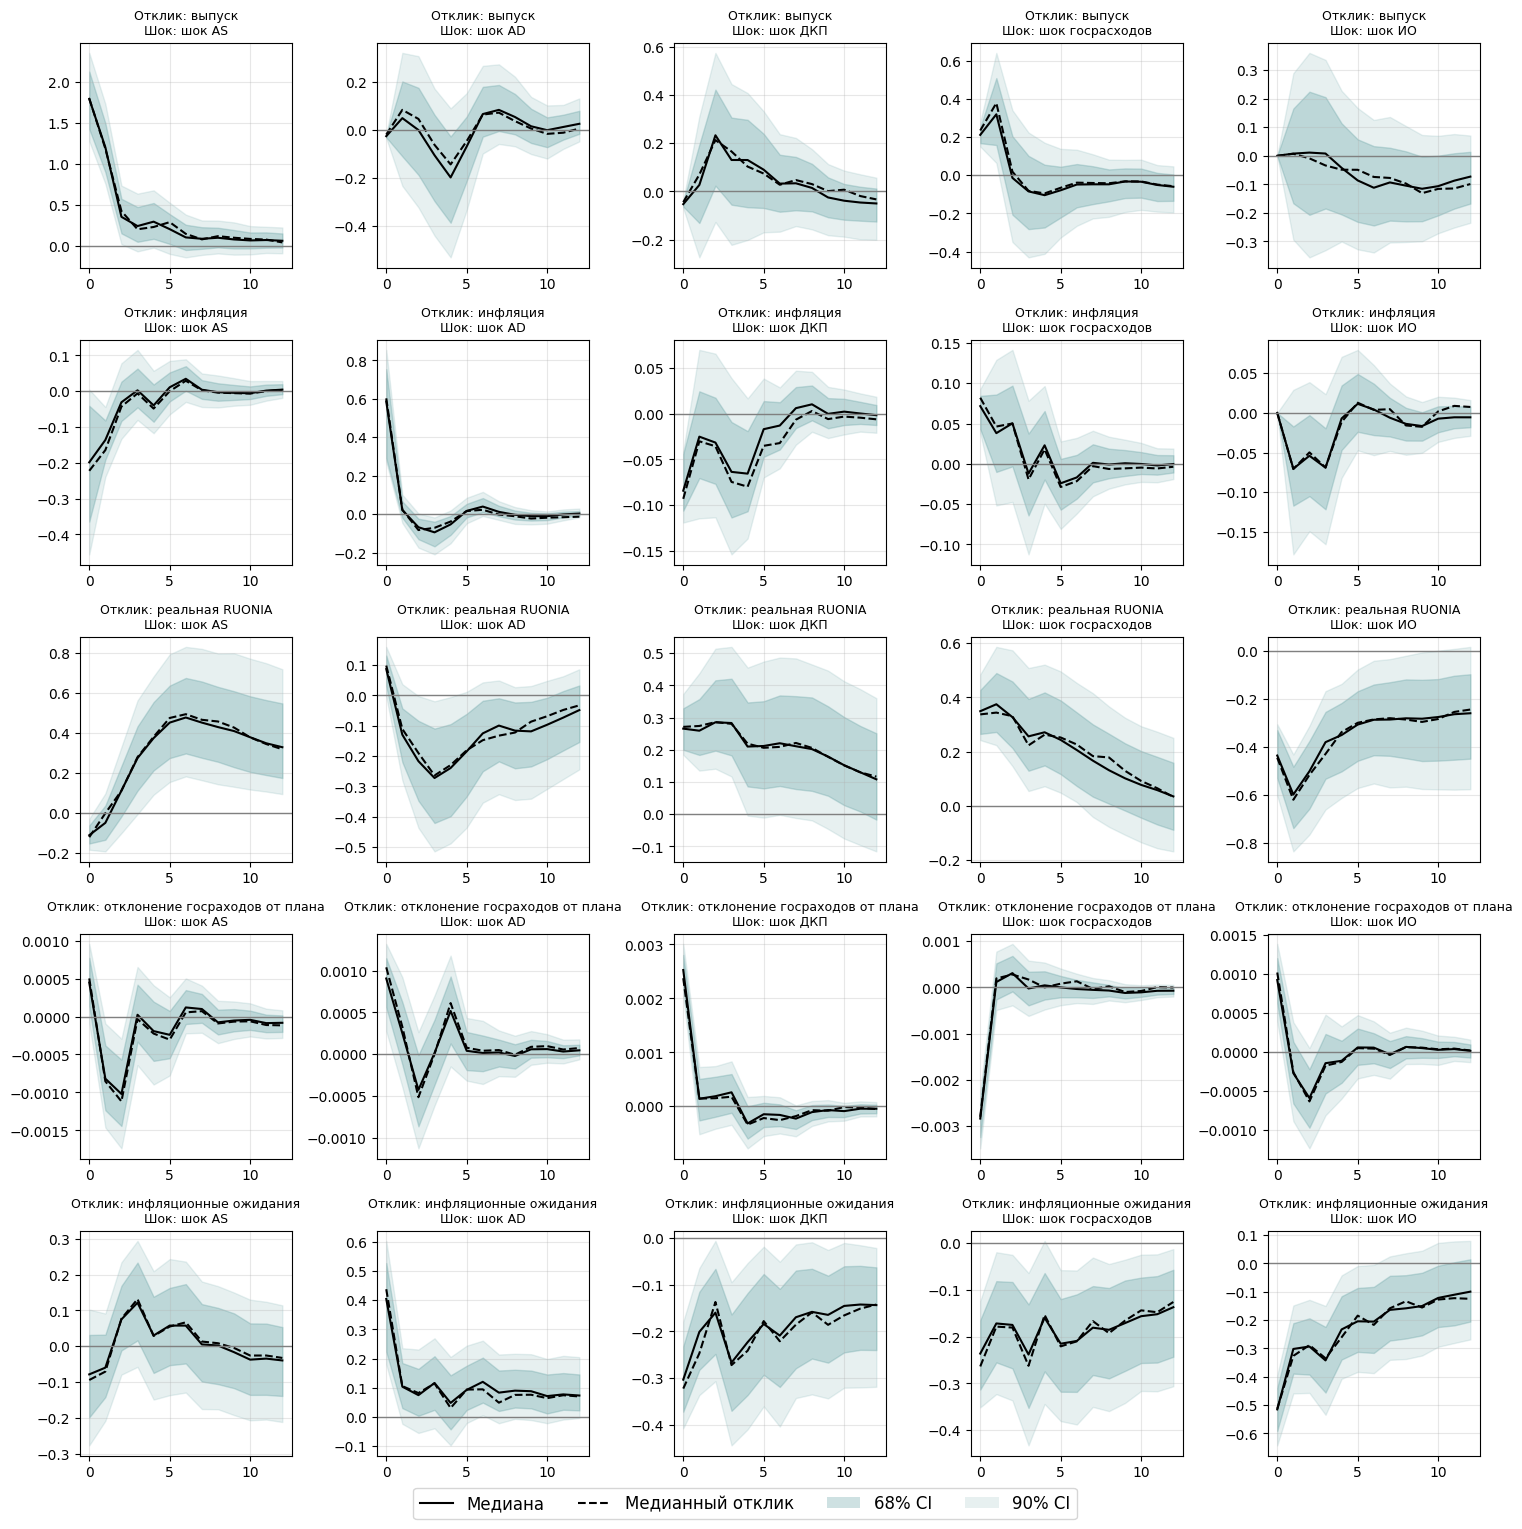

In [22]:
# Альтернативный вариант с общей легендой
fig, axes = plt.subplots(K_endo, K_endo, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Создаем прокси для легенды
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='black', label='Медиана'),
    Line2D([0], [0], color='black', ls='--', label='Медианный отклик'),
    Patch(facecolor='cadetblue', alpha=0.3, label='68% CI'),
    Patch(facecolor='cadetblue', alpha=0.15, label='90% CI')
]

for i in range(K_endo):
    for j in range(K_endo):
        ax = axes[i, j]
        
        responses = np.vstack([irf[:, i, j] for irf in IRF_ortho])
        med = np.median(responses, axis=0)
        median_index = pd.DataFrame((responses - med)**2).sum(1).sort_values().index[0]
        med_res = responses[median_index, :]
        
        median = np.percentile(responses, 50, axis=0)
        lower68 = np.percentile(responses, 16, axis=0)
        upper68 = np.percentile(responses, 84, axis=0)
        lower90 = np.percentile(responses, 5, axis=0)
        upper90 = np.percentile(responses, 95, axis=0)

        x_axis = np.arange(horizon+1)
        
        ax.plot(x_axis, median, color='black')
        ax.plot(x_axis, med_res, color='black', ls='--')
        ax.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3)
        ax.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15)
        ax.axhline(0, color='grey', lw=1)
        
        # Заголовок указывает, что строка - отклик, столбец - шок
        ax.set_title(f"Отклик: {y_dict[i]}\nШок: {u_dict[j]}", fontsize=9)
        ax.grid(True, alpha=0.3)

# Добавляем общую легенду
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 0.01), ncol=4, fontsize=12)

#fig.suptitle('Функции импульсного отклика (IRF)', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

In [ ]:
short_sign_restrictions_base = [
    (2, 2, 0, 1),
    (2, 2, 1, 1),
    (2, 2, 2, 1),
    (2, 2, 3, 1),
    (3, 3, 0, 1),
    (3, 3, 1, 1),
    (3, 3, 2, 1),
    (3, 3, 3, 1),
    (1, 2, 1,-1),
    (1, 2, 2,-1),
    (0, 0, 0, 1),
    (0, 3, 0, 1),
    (0, 3, 1, 1),
    (1, 1, 0, 1),
    (2, 2, 0, 1)
]
short_sign_restrictions_full = [
    (0, 0, 0, 1), # price puzle                                      horizon = 1
    (0, 0, 1, 1), # identification of monetary shock through output  horizon = 1
    (0, 1, 1, 1), # identification of monetary shock through output  horizon = 1
    (1, 1, 1, 1), # identification of monetary shock through output  horizon = 1
    (1, 1, 0, 1),
    (0, 2, 1,-1),
    (1, 0, 0,-1),
    (2, 0, 0,-1),
    (2, 1, 0, 1),
    (2, 2, 0, 1),
    (3, 1, 1, 1),
    (3, 2, 1,-1),
    (4, 1, 0, 1),
    (4, 1, 1, 1),
    (0, 3, 0, 1),
    (1, 3, 0, 1),
    (3, 3, 0, 1),
    (4, 3, 0, 1),
    (0, 3, 1, 1),
    (1, 3, 1, 1),
    (3, 3, 1, 1),
    (4, 3, 1, 1),
    (1, 4, 0, 1),
    (2, 4, 0, 1),
    (4, 4, 0, 1),
    (0, 4, 1, 1),
    (1, 4, 1, 1),
    (2, 4, 1, 1),
    (4, 4, 1, 1)
]

In [5]:
monthly_data.columns.tolist()

['key_rate',
 'infl',
 'target',
 'dollar_m',
 'm0',
 'm1',
 'm2',
 'pi_e_ws',
 'pi_e_wos',
 'pi_e',
 'credits_hh',
 'PMI_manufacturing',
 'PMI_service',
 'price_brent',
 'ruonia_1w',
 'ruonia_2w',
 'ruonia_1m',
 'ruonia_2m',
 'ruonia_3m',
 'ruonia_6m',
 'ruonia_1y',
 'ruonia_2y',
 'rate_1',
 'rate_05',
 'rate_025',
 'inf_us',
 'inf_us_cum',
 'igrea',
 'all_items',
 'ru_cpi',
 'ru_cpi_wo_servises',
 'ruonia',
 'm2x_sa_mom',
 'm2_sa_mom',
 'm1_sa_mom',
 'govspend',
 'real_brent',
 'rcwos_c',
 'rc_c',
 'real_dollar',
 'real_rate',
 'real_ruonia',
 'log_credits_hh',
 'spread',
 'spread_3m',
 'spread_1m',
 'pi_spread']

In [15]:
for v in range(100):
    x, y = np.exp(2*v/10), 2*np.exp(1*v/10)
    bul = x > y
    print(np.round(x, 4), np.round(y, 4), bul)

1.0 2.0 False
1.2214 2.2103 False
1.4918 2.4428 False
1.8221 2.6997 False
2.2255 2.9836 False
2.7183 3.2974 False
3.3201 3.6442 False
4.0552 4.0275 True
4.953 4.4511 True
6.0496 4.9192 True
7.3891 5.4366 True
9.025 6.0083 True
11.0232 6.6402 True
13.4637 7.3386 True
16.4446 8.1104 True
20.0855 8.9634 True
24.5325 9.9061 True
29.9641 10.9479 True
36.5982 12.0993 True
44.7012 13.3718 True
54.5982 14.7781 True
66.6863 16.3323 True
81.4509 18.05 True
99.4843 19.9484 True
121.5104 22.0464 True
148.4132 24.365 True
181.2722 26.9275 True
221.4064 29.7595 True
270.4264 32.8893 True
330.2996 36.3483 True
403.4288 40.1711 True
492.749 44.3959 True
601.845 49.0651 True
735.0952 54.2253 True
897.8473 59.9282 True
1096.6332 66.2309 True
1339.4308 73.1965 True
1635.9844 80.8946 True
1998.1959 89.4024 True
2440.602 98.8049 True
2980.958 109.1963 True
3640.9503 120.6806 True
4447.0667 133.3727 True
5431.6596 147.3996 True
6634.244 162.9017 True
8103.0839 180.0343 True
9897.1291 198.9686 True
12088.380

In [5]:
for irf in model.irf(horizon=1):
    print(pd.DataFrame(irf))
print(pd.DataFrame(model.Upsilon))

          0         1         2         3         4
0  1.717804  0.111571 -0.332232  0.875774  0.393020
1 -0.348237  0.566988  0.041782  0.169624 -0.087589
2 -0.099272  0.295561 -0.149321 -0.323928  0.526878
3  0.001127  0.000437  0.004272 -0.000294 -0.000632
4 -0.493806  0.172922  0.145110  0.538285  0.413844
          0         1         2         3         4
0  1.268564  0.257428 -0.351801  0.523164  0.310689
1 -0.176833  0.043920 -0.035562 -0.047798  0.035133
2 -0.037114  0.086674 -0.242177 -0.394650  0.758818
3 -0.000784  0.000324  0.000203 -0.000428  0.000116
4 -0.302328 -0.044185  0.076704  0.308135  0.256889
          0         1         2         3          4
0  3.646379 -0.469677  0.810111  5.026064   4.052620
1 -0.817895  0.322661 -0.106210  0.436839   0.255666
2  5.035682 -1.700265  0.240091  6.603963  16.979737
3 -0.003538  0.000958  0.004518 -0.001397  -0.002771
4 -7.497172 -1.217269  2.410126  8.139536   2.399356


In [24]:
contrib = model.historical_decomposition()
contrib.shape

(5, 123, 5)

In [34]:
127/22


5.7727272727272725

In [ ]:
B0 = np.linalg.inv(model.P @ model.Q)
U = B0 @ model.E
U = np.flip(U, axis = 1)
T = U.shape[1]
irf = SVAR_KL._irf_companion(model.B_hat_endo[:, 1:],B0, T)
hd = [irf[0]*U[:, 0]]
chd = [irf[0]*U[:, 0]]
for t in range(1, T):
    contrib_t = irf[0]*U[:, t]
    
    hd.append(contrib_t)

    contrib_c = irf[0]*U[:, t]
    for h in range(1, t):  
        contrib_c += irf[h]*U[:, t-h] #Этот цикл отвечает за накопленные отклики
    chd.append(contrib_c)

    del contrib_t, contrib_c

variable_of_interest = 4 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 3 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

variable_of_interest = 2 #Инетерсующая нас переменная
y_hd = hd[0][variable_of_interest, :]
y_chd = chd[0][variable_of_interest, :]
for hd_t in hd[1:]:
    y_hd = np.vstack([y_hd, hd_t[variable_of_interest, :]]) 
for chd_t in chd[1:]:
    y_chd = np.vstack([y_chd, chd_t[variable_of_interest, :]])
y_hd = pd.DataFrame(y_hd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот не накопленные отклики

y_hd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_hd.index]


y_chd = pd.DataFrame(y_chd, columns = [i for i in u_dict.values()], 
                    index = data.columns[:T].to_list()[::-1]) #вот накопленные отклики
y_chd[y_dict[variable_of_interest]] = data_endo.T[y_dict[variable_of_interest]].loc[y_chd.index]
plot_hd_bars_signed(y_chd, variable_name=y_dict[variable_of_interest])
plot_hd_bars_signed(y_hd, variable_name=y_dict[variable_of_interest], cumm=False)

,2025-07-01,2025-06-01,2025-05-01,2025-04-01,2025-03-01,2025-02-01,2025-01-01,2024-12-01,2024-11-01,2024-10-01,...,2015-10-01,2015-09-01,2015-08-01,2015-07-01,2015-06-01,2015-05-01,2015-04-01,2015-03-01,2015-02-01,2015-01-01
PMI_manufacturing,-3.774797,-3.652846,-0.325573,-0.380118,-2.852846,-1.452846,0.974427,-1.180118,-0.607391,-0.825573,...,0.342276,-0.521360,-1.712269,-0.732742,-0.710791,-1.183518,0.961936,-1.210791,-0.210791,-2.783518
ru_cpi,-0.316267,-0.336867,-0.242479,-0.306467,-0.079319,0.063876,0.139209,0.429199,0.336873,0.366330,...,-0.107753,-0.083392,0.017495,-0.285386,-0.288914,-0.215638,-0.090351,0.523149,1.455597,2.482129
real_ruonia,5.139010,5.143301,4.884079,4.405812,4.285440,4.945069,4.993970,5.720970,6.326494,5.423112,...,-4.118169,-4.116047,-4.640636,-3.789260,-2.778621,-3.375363,-2.931969,-3.213705,-1.933132,1.089285
spread_3m,1.939135,0.781193,1.260428,0.103590,0.766973,0.132983,0.109144,-1.138161,-1.410217,-1.173754,...,0.292986,-0.027083,-0.375508,-0.040789,0.509296,0.047805,0.668311,0.497733,-0.144377,-2.348797
log_credits_hh,-0.096406,-0.086346,-0.082164,-0.077051,-0.071438,-0.069534,-0.058733,-0.014818,0.015449,0.025838,...,0.048007,0.060690,0.086936,0.100444,0.117438,0.133447,0.152520,0.177083,0.199646,0.228935
real_brent,-5.360678,-4.041552,-5.252878,-4.225030,-2.571564,-1.623382,-0.133063,-1.301953,-2.312713,-2.852753,...,-4.454908,-4.645519,-4.225194,-1.787567,2.202691,3.218217,1.849377,0.518234,1.201854,-1.742689
pi_e,2.669904,2.727138,3.410845,3.054134,1.532012,1.975485,2.249895,1.794832,1.951530,2.076625,...,3.067810,3.883423,2.980463,2.615503,3.720581,3.388204,2.968513,3.313873,5.380410,3.836426
real_dollar,-5.124815,-5.266979,-4.738461,-4.511481,-4.729992,0.083156,5.262579,7.092760,7.285166,5.644690,...,3.903410,6.937763,6.801027,2.327151,0.288980,-3.200444,-2.802542,1.421163,6.182079,5.043736
govspend,0.002974,-0.002191,-0.004871,0.000254,-0.004518,0.003793,0.010030,0.004817,0.000957,0.003791,...,-0.002315,-0.006309,0.001325,0.004232,-0.000972,-0.000145,0.007765,-0.003736,0.007159,0.011916
covid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
SVAR_KL.

In [4]:
pd.DataFrame(model.Upsilon)

,0,1,2,3,4
0,-6.120881,-0.000555,-1.509293,0.668279,-0.967533
1,0.509609,-0.296421,-0.365242,-0.264222,0.518177
2,-10.800742,1.383045,0.257476,10.998543,2.507924
3,-1.320880,-10.182400,-4.499097,-2.628264,1.000199
4,3.511736,2.771203,-6.696785,-0.100899,0.720493


In [5]:
data.to_pickle('data.pkl')

In [6]:
pd.read_pickle('data.pkl')

,2025-07-01,2025-06-01,2025-05-01,2025-04-01,2025-03-01,2025-02-01,2025-01-01,2024-12-01,2024-11-01,2024-10-01,...,2015-10-01,2015-09-01,2015-08-01,2015-07-01,2015-06-01,2015-05-01,2015-04-01,2015-03-01,2015-02-01,2015-01-01
PMI_manufacturing,-3.774797,-3.652846,-0.325573,-0.380118,-2.852846,-1.452846,0.974427,-1.180118,-0.607391,-0.825573,...,0.342276,-0.521360,-1.712269,-0.732742,-0.710791,-1.183518,0.961936,-1.210791,-0.210791,-2.783518
ru_cpi,-0.316267,-0.336867,-0.242479,-0.306467,-0.079319,0.063876,0.139209,0.429199,0.336873,0.366330,...,-0.107753,-0.083392,0.017495,-0.285386,-0.288914,-0.215638,-0.090351,0.523149,1.455597,2.482129
real_ruonia,5.139010,5.143301,4.884079,4.405812,4.285440,4.945069,4.993970,5.720970,6.326494,5.423112,...,-4.118169,-4.116047,-4.640636,-3.789260,-2.778621,-3.375363,-2.931969,-3.213705,-1.933132,1.089285
spread_3m,1.939135,0.781193,1.260428,0.103590,0.766973,0.132983,0.109144,-1.138161,-1.410217,-1.173754,...,0.292986,-0.027083,-0.375508,-0.040789,0.509296,0.047805,0.668311,0.497733,-0.144377,-2.348797
log_credits_hh,-0.096406,-0.086346,-0.082164,-0.077051,-0.071438,-0.069534,-0.058733,-0.014818,0.015449,0.025838,...,0.048007,0.060690,0.086936,0.100444,0.117438,0.133447,0.152520,0.177083,0.199646,0.228935
real_brent,-5.360678,-4.041552,-5.252878,-4.225030,-2.571564,-1.623382,-0.133063,-1.301953,-2.312713,-2.852753,...,-4.454908,-4.645519,-4.225194,-1.787567,2.202691,3.218217,1.849377,0.518234,1.201854,-1.742689
pi_e,2.669904,2.727138,3.410845,3.054134,1.532012,1.975485,2.249895,1.794832,1.951530,2.076625,...,3.067810,3.883423,2.980463,2.615503,3.720581,3.388204,2.968513,3.313873,5.380410,3.836426
real_dollar,-5.124815,-5.266979,-4.738461,-4.511481,-4.729992,0.083156,5.262579,7.092760,7.285166,5.644690,...,3.903410,6.937763,6.801027,2.327151,0.288980,-3.200444,-2.802542,1.421163,6.182079,5.043736
covid,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
